In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# 데이터셋 로드 및 전처리
digits = load_digits()
X = digits.data
y = digits.target
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

In [3]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.net(x)

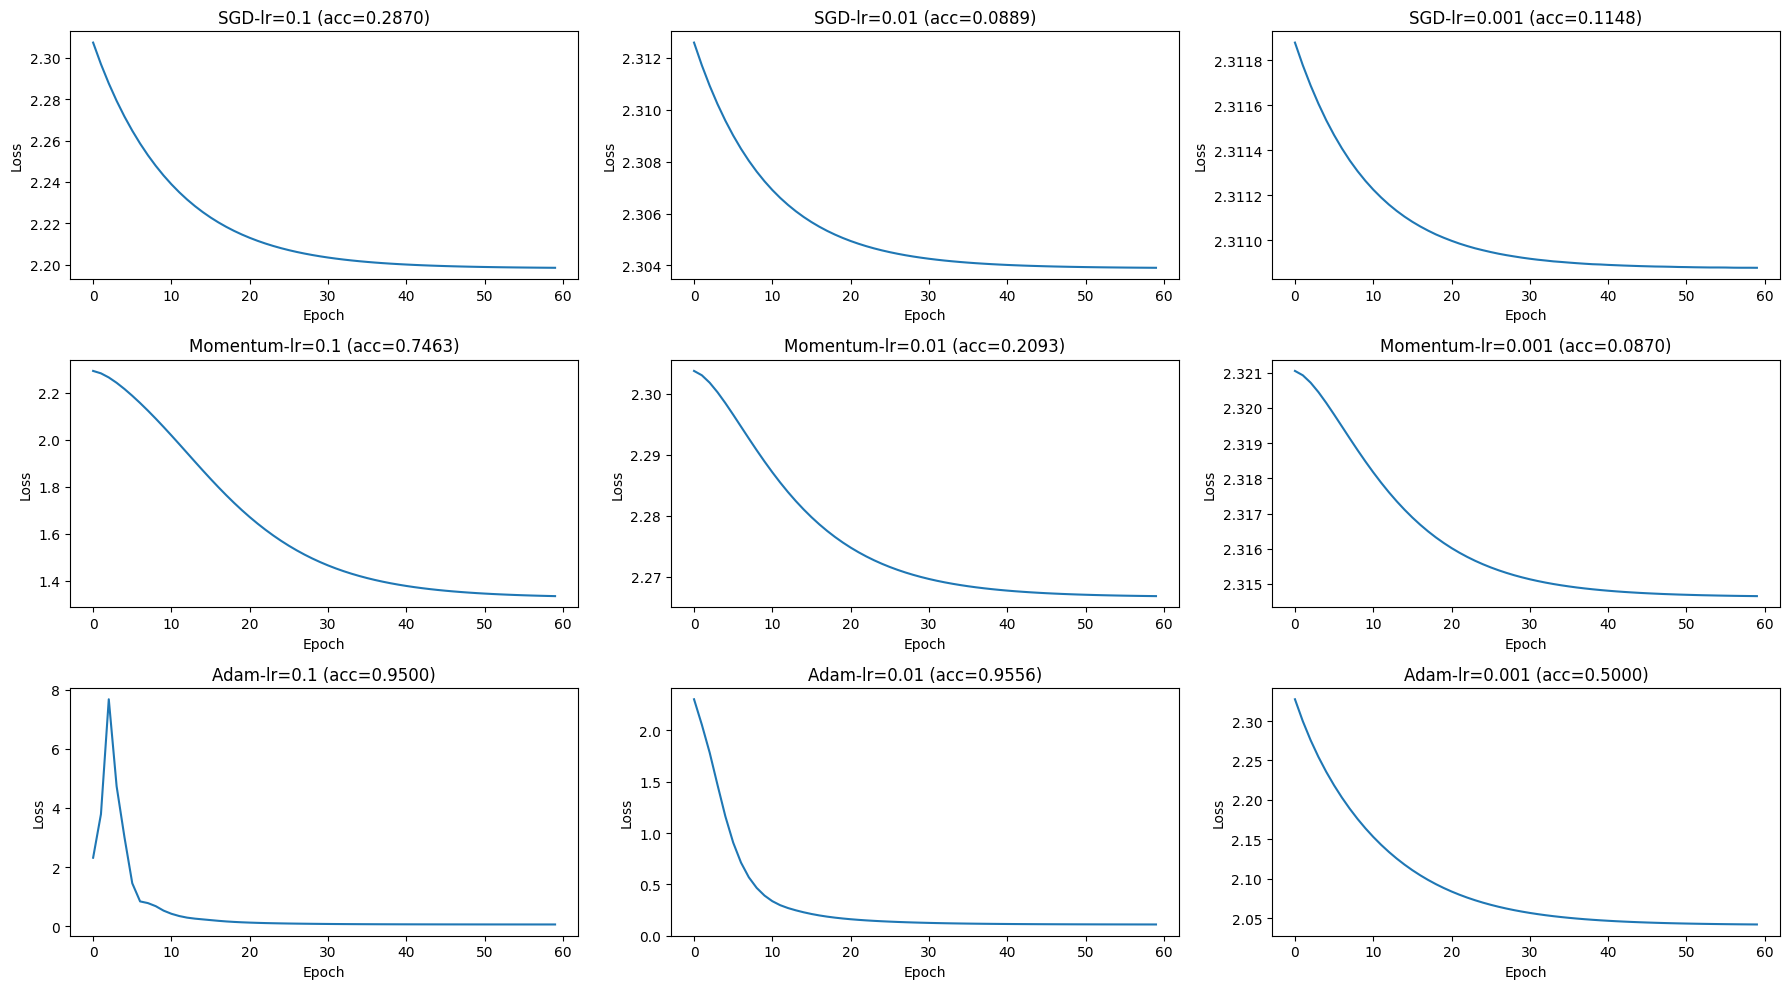


[최종 정확도 요약표]
Optimizer	LR=0.1		LR=0.01		LR=0.001
SGD		0.2870		0.0889		0.1148		
Momentum		0.7463		0.2093		0.0870		
Adam		0.9500		0.9556		0.5000		


In [ ]:


# 학습 함수 정의
def train_model(optimizer_type, lr):
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_type == 'Momentum':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    #Learning rate를 지수 감소 (Exponential Decay) 적용하여 실험  
    scheduler = ExponentialLR(optimizer, gamma=0.9)

    train_losses = []
    for epoch in range(60):
        model.train()

        #미분 결과 초기화
        optimizer.zero_grad()
        #
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())

    # 평가
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == y_test).float().mean().item()

    return train_losses, acc

# 실험 실행
optimizers = ['SGD', 'Momentum', 'Adam']
lrs = [0.1, 0.01, 0.001]
results = {}

plt.figure(figsize=(18, 10))
for i, opt in enumerate(optimizers):
    for j, lr in enumerate(lrs):
        losses, acc = train_model(opt, lr)
        label = f'{opt}-lr={lr}'
        results[label] = acc

        plt.subplot(3, 3, i*3 + j + 1)
        plt.plot(losses)
        plt.title(f'{label} (acc={acc:.4f})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

plt.tight_layout()
plt.show()

